In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from collections import Counter 
from __future__ import print_function
from nltk.stem.porter import PorterStemmer

np.random.seed(42)

In [21]:
def data_loader():
    with open("assign_4_data.txt","r") as f:
        output_wordlist = [r.split()[0] for r in f]
        f.close()
    with open("data.txt","r") as f:
        data = f.readlines()
    with open("data.txt","r") as f:
        text = f.read()
        
    return data, text, output_wordlist

In [22]:
data, text, output_wordlist = data_loader()

## Preprocessing

In [23]:
def preprocessing(data, text, output_wordlist):
    
    
    #### Part 1: Break each message into tokens
    # sentences = sent_tokenize(text)
    n = len(data)
    tokenized_data = []
    for i in range(0,n):
        test = str(data[i])
        tokens = word_tokenize(test)
        words = [word for word in tokens if word.isalpha()]
        tokenized_data.append(words)

    tokens = word_tokenize(text)
    temp_vocab = [word for word in tokens if word.isalpha()]

    
    #### Part 2: Removing English stopwords
    stop_words = stopwords.words('english')
    stop_words = [word.lower() for word in stop_words]
    temp_vocab = [word.lower() for word in temp_vocab]
    for i in range(0,n):
        tokens = tokenized_data[i]
        words = [word.lower() for word in tokens]
        tokenized_data[i] = words
    noSW_tokenized_data = []
    for i in range(0,n):
        tokens = tokenized_data[i]
        words = [w for w in tokens if not w in stop_words]
    #     print(words)
        noSW_tokenized_data.append(words)
    noSW_vocab = [w for w in temp_vocab if not w in stop_words]

    
    
    #### Part 3: Porter Stemming
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stemmed_data = []
    for i in range(0,n):
        words = [porter.stem(word) for word in noSW_tokenized_data[i]]
        stemmed_data.append(words)
    stemmed_vocab = [porter.stem(word) for word in noSW_vocab]

    
    
    ### Vocabulary creation
    counter = Counter(stemmed_vocab)
    most_frequent_count = 500
    most_occur = counter.most_common(most_frequent_count)
    vocab = []
    for word in most_occur:
        vocab.append(word[0]) 

    V = len(vocab)
    token_vector =  np.zeros((n, V)).tolist()
    for i in range(0,V):
        word = vocab[i]
        for j in range(0,n):
            for w in stemmed_data[j]:
                if word == w:
                    token_vector[j][i] = 1

                    
    #### Target Variable definition
    output_wordlist_num = []
    for word in output_wordlist:
        if word == 'ham':
            output_wordlist_num.append(1)
        elif word == 'spam':
            output_wordlist_num.append(0)
    
    token_vector = np.array(token_vector)
    output_wordlist_num = np.array(output_wordlist_num)

    
    
    #### Test-Train split
    train_split = 0.8
    train_size = int(train_split*n)

    X_train = token_vector[0:train_size]
    Y_train = output_wordlist_num[0:train_size]
    X_test = token_vector[train_size:]
    y_test = output_wordlist_num[train_size:].reshape((-1, 1)) 
    X = X_train
    y = Y_train.reshape((-1, 1)) 
    
    return X_train, Y_train, X_test, y_test, X, y

In [24]:
X_train, y_train, X_test, y_test, X, y = preprocessing(data, text, output_wordlist)

In [25]:
Y_train = np.zeros((len(y_train), 2))
Y_test = np.zeros((len(y_test), 2))
Y = Y_train

In [26]:
for i in range(0, len(y_train)):
    if y_train[i] == 0:
        Y_train[i][0] = 1
    if y_train[i] == 1:
        Y_train[i][1] = 1
        
for i in range(0, len(y_test)):
    if y_test[i] == 0:
        Y_test[i][0] = 1
    if y_test[i] == 1:
        Y_test[i][1] = 1

## Part 2:

#we have 4 layers: input layer, 2-hidden layer and output layer
#input layer has 500 nodes (Vocabulary size = 500)
#hidden layer has from command line nodes
#output layer has 2 node

In [27]:
layer1_node = int(input("Enter the number of nodes in hidden layer 1: "))
layer2_node = int(input("Enter the number of nodes in hidden layer 2: "))

Enter the number of nodes in hidden layer 1: 10
Enter the number of nodes in hidden layer 2: 5


In [28]:
def weight_initialiser(X_train, hidden_layer_nodes1 =100, hidden_layer_nodes2 =100, output_nodes=2):
    dim1 = len(X_train[0])
    dim2 = hidden_layer_nodes1
    dim3 = hidden_layer_nodes2
    dim4 = output_nodes
    weight0 = 2 * np.random.random((dim1, dim2)) - 1
    weight1 = 2 * np.random.random((dim2, dim3)) - 1
    weight2 = 2 * np.random.random((dim3, dim4)) - 1
    
    return weight0, weight1, weight2

In [29]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [30]:
def sigmoid_derivative(x):
    return x * (1.0 - x)

In [31]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def CrossEntropy_Loss(t, p):
    y = softmax(p)
    return (-np.mean(np.multiply(t, np.log(y+1e-9))))

def loss_derivative(t, p):
    y = softmax(p)
    return (y-t)

In [32]:
def forward(X_train, weight0, weight1, weight2):
    layer_0 = X_train
    layer_1 = sigmoid(np.dot(layer_0,weight0))
    layer_2 = sigmoid(np.dot(layer_1,weight1))
    layer_3 = softmax(np.dot(layer_2,weight2))
    
    return layer_0, layer_1, layer_2, layer_3

In [33]:
def backward(weight0, weight1, weight2, layer_0, layer_1, layer_2, layer_3, y, learning_rate):

    W1, W2, W3 = weight0, weight1, weight2
    
    a0, a1, a2,a3 = layer_0, layer_1, layer_2, layer_3

    m = y.shape[0]
    
    loss = CrossEntropy_Loss(a3, y)
    

    dz3 = loss_derivative(t=y,p=a3)

    dW3 = 1/m*(a2.T).dot(dz3) #dW2 = 1/m*(a1.T).dot(dz2) 
    
    dz2 = np.multiply(dz3.dot(W3.T) ,sigmoid_derivative(a2))
    
    dW2 = 1/m*np.dot(a1.T, dz2)
    
    
    dz1 = np.multiply(dz2.dot(W2.T),sigmoid_derivative(a1))
    
    dW1 = 1/m*np.dot(a0.T,dz1)
    
    W1 += learning_rate * dW1
    W2 += learning_rate * dW2
    W3 += learning_rate * dW3
    
    return W3, W2, W1, loss

In [34]:
def gradientDescent(X, y, X_test, y_test, learning_rate = 0.1): 
    weight0, weight1, weight2 = weight_initialiser(X_train, layer1_node, layer2_node, output_nodes=2)
    error_list = [] 
    test_error_list = []
    iterations = 1000
    for itr in range(iterations):
        layer_0, layer_1, layer_2, layer_3 = forward(X, weight0, weight1, weight2)
        weight2,weight1, weight0, loss  = backward(weight0, weight1, weight2, layer_0, layer_1, layer_2, layer_3, y, learning_rate)
#         print(itr, loss)
        error_list.append(loss)
        
        test_layer_0 = X_test
        test_layer_1 = sigmoid(np.dot(test_layer_0,weight0))
        test_layer_2 = sigmoid(np.dot(test_layer_1,weight1))
        test_layer_3 = softmax(np.dot(test_layer_2,weight2))
        correct = 0
        for i in range(len(test_layer_3)):
            if(test_layer_3[i][0] > test_layer_3[i][1]):
                test_layer_3[i][0] = 1
                test_layer_3[i][1] = 0
            else:
                test_layer_3[i][0] = 0
                test_layer_3[i][1] = 1
#             print(test_layer_3[i], y_test[i])
            if(test_layer_3[i][0] == y_test[i][0] and test_layer_3[i][1] == y_test[i][1]):
                correct += 1
        accuracy = correct * 100.0 / len(test_layer_3)
        test_error_list.append((100-accuracy)/100)
        
    return weight0, weight1, weight2, error_list, test_error_list, accuracy 

In [35]:
weight0, weight1, weight2, error_list, test_error_list, accuracy  = gradientDescent(X, Y, X_test, Y_test, learning_rate = 0.1)

## Train Error vs Epochs

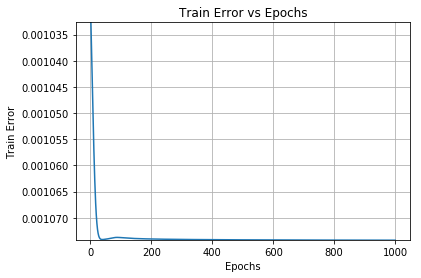

In [36]:
epochs = []
for i in range(0,1000):
    epochs.append(i+1)
plt.ylabel('Train Error')
plt.xlabel('Epochs')
plt.title("Train Error vs Epochs")
plt.grid(True)
plt.ylim(0.001074196492636784 , 0.001032662810722979)
plt.plot(epochs, error_list)

## Test Error vs Epochs

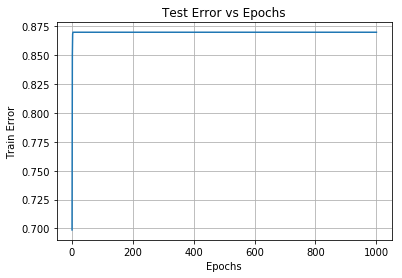

In [37]:
epochs = []
for i in range(0,1000):
    epochs.append(i+1)
plt.ylabel('Train Error')
plt.xlabel('Epochs')
plt.grid(True)
plt.title("Test Error vs Epochs")
plt.plot(epochs, test_error_list)

## Test Set

In [38]:
test_layer_0 = X_test
test_layer_1 = sigmoid(np.dot(test_layer_0,weight0))
test_layer_2 = sigmoid(np.dot(test_layer_1,weight1))
test_layer_3 = softmax(np.dot(test_layer_2,weight2))
correct = 0
for i in range(len(test_layer_3)):
    if(test_layer_3[i][0] > test_layer_3[i][1]):
        test_layer_3[i][0] = 1
        test_layer_3[i][1] = 0
    else:
        test_layer_3[i][0] = 0
        test_layer_3[i][1] = 1
#             print(test_layer_3[i], y_test[i])
    if(test_layer_3[i][0] == Y_test[i][0] and test_layer_3[i][1] == Y_test[i][1]):
        correct += 1
print('total =', len(test_layer_3))
print('correct =', correct)
print ('accuracy = ', correct * 100.0 / len(test_layer_3))

total = 1115
correct = 145
accuracy =  13.004484304932735
